In [ ]:
import torch


In [ ]:
# torch.cuda.is_available()
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())

### Data Exploration and Image Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
sns.set()

In [2]:
train_df = pd.read_csv("data/train-small.csv")
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in this data frame')
train_df.head()

There are 1000 rows and 16 columns in this data frame


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [3]:
print(f"Total number of patient ids are {train_df['PatientId'].count()},\
from those the unique ids are {train_df['PatientId'].value_counts().shape[0]}")

Total number of patient ids are 1000,from those the unique ids are 928


In [4]:
# list of all the diseases 
columns = train_df.keys()
columns = list(columns)
print(columns)

['Image', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'PatientId', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [5]:
# Removing unncesessary coolumns

columns.remove('Image')
columns.remove('PatientId')

print(f"There are {len(columns)} columns of labels for these conditions: {columns}")

There are 14 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [6]:
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

The class Atelectasis has 106 samples
The class Cardiomegaly has 20 samples
The class Consolidation has 33 samples
The class Edema has 16 samples
The class Effusion has 128 samples
The class Emphysema has 13 samples
The class Fibrosis has 14 samples
The class Hernia has 2 samples
The class Infiltration has 175 samples
The class Mass has 45 samples
The class Nodule has 54 samples
The class Pleural_Thickening has 21 samples
The class Pneumonia has 10 samples
The class Pneumothorax has 38 samples


Displaying the Random Images...


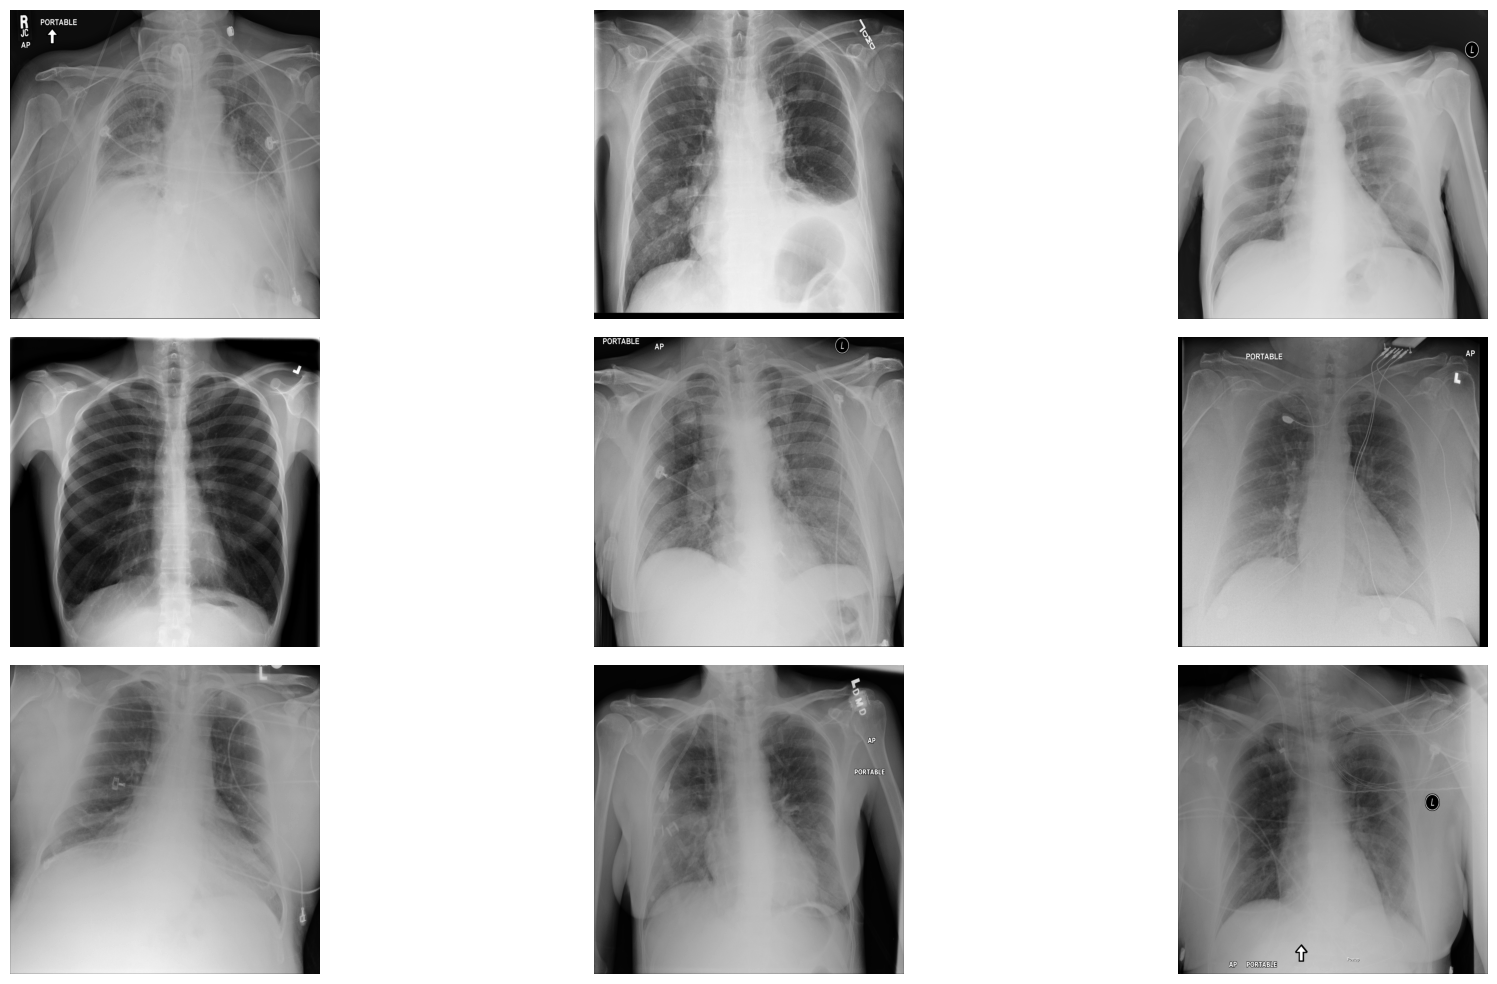

In [7]:
images = train_df['Image'].values

random_images = [np.random.choice(images) for i in range(9)]

img_dir = 'data/nih/images-small/'

print('Displaying the Random Images...')

plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap="gray")
    plt.axis('off')
plt.tight_layout()

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 0.9804 and the minimum is 0.0000
The mean value of the pixels is 0.4796 and the standard deviation is 0.2757


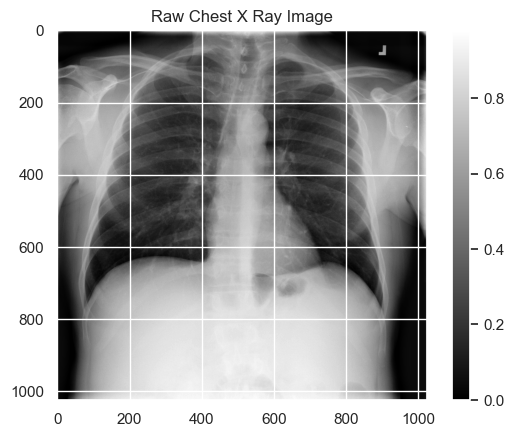

In [8]:
# detailed investigating the single image
sample_img = train_df.Image[0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap="gray")
plt.colorbar()
plt.title("Raw Chest X Ray Image")
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

C:\Users\manin\AppData\Local\Temp\ipykernel_30132\2066625508.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_image.ravel(),


Text(0, 0.5, '# Pixels in Image')

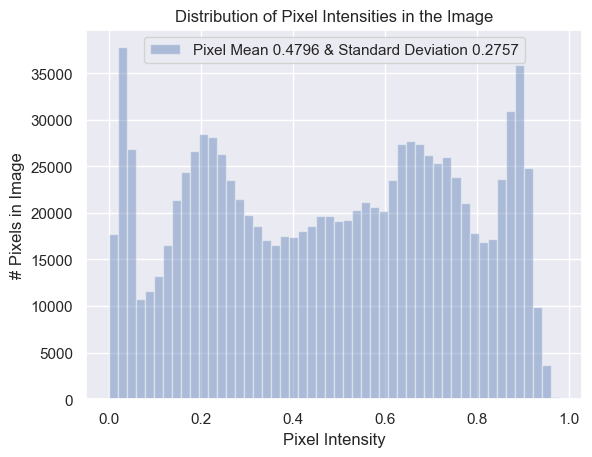

In [9]:
# pixel value distribution
import warnings

sns.distplot(raw_image.ravel(),
             label=f"Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [10]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Sample-wise normalisation class
class SamplewiseNormalize:
    def __call__(self,img):
        img = torch.tensor(img, dtype = torch.float32)
        mean = img.mean()
        std = img.std()
        if std == 0 :
            std = 1
        img = (img - mean) / std
        return img

# Custom dataset to handle the DataFrame Input
class CustomImageDataset(Dataset):
    def __init__(self,dataframe,directory,
               x_col,y_col,transform=None,
               target_size=(320,320)):
        self.dataframe = dataframe
        self.directory = directory
        self.x_col = x_col
        self.y_col = y_col
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self,idx):
        img_path = f"{self.directory}/{self.dataframe.iloc[idx][self.x_col]}"
        img = Image.open(img_path).convert("RGB")
        img = img.resize(self.target_size)
        # plt.imshow(img, cmap="gray")

        label = torch.tensor(self.dataframe.iloc[idx][self.y_col],
                            dtype = torch.float32)

        if self.transform:
            img = self.transform(img)

        return img,label

transform = transforms.Compose([
    transforms.ToTensor(),
    SamplewiseNormalize()
])


In [11]:
dataset = CustomImageDataset(
    dataframe=train_df,
    directory="data/nih/images-small/",
    x_col="Image",
    y_col=["Mass"],
    transform=transform,
    target_size=(320, 320)
)

In [12]:
data_loader = DataLoader(dataset,batch_size = 1, shuffle=False,num_workers = 4)

C:\Users\manin\AppData\Local\Temp\ipykernel_30132\1024108159.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.dataframe.iloc[idx][self.y_col],
C:\Users\manin\AppData\Local\Temp\ipykernel_30132\1024108159.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype = torch.float32)


The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 1.7608 and the minimum is -1.7409
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


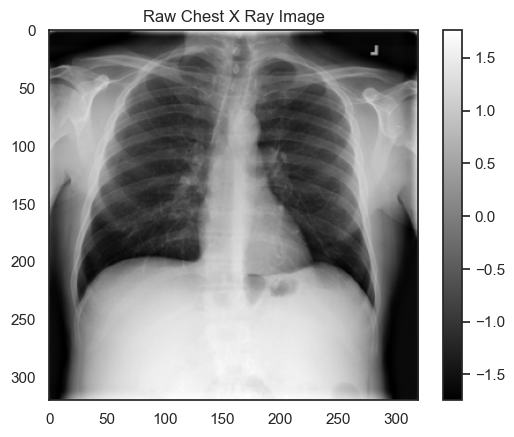

In [13]:
# Plot a processed image
sns.set_style("white")
generated_image, label = dataset.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [ ]:

# Set Seaborn style to "white"
sns.set_style("white")

# Get the first batch from the DataLoader
data_iter = iter(data_loader)
generated_image, label = next(data_iter)

# Convert the generated image tensor to a NumPy array for visualization
# Transpose dimensions from (C, H, W) to (H, W, C)
generated_image_np = generated_image[0].permute(1, 2, 0).numpy()

# Plot the image
plt.imshow(generated_image_np, cmap='gray')
plt.axis('off')
plt.title(f"Label: {label[0].item()}")
plt.show()

C:\Users\manin\AppData\Local\Temp\ipykernel_30132\753195075.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_image.ravel(),


TypeError: mean() received an invalid combination of arguments - got (axis=NoneType, dtype=NoneType, out=NoneType, ), but expected one of:
 * (*, torch.dtype dtype = None)
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


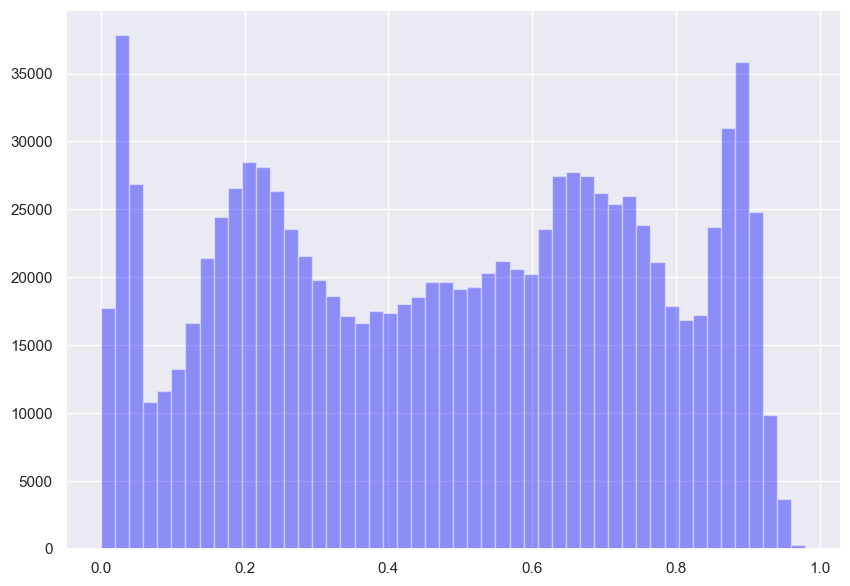

In [15]:
# Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for original iamge
sns.distplot(raw_image.ravel(), 
             label=f'Original Image: mean {np.mean(raw_image):.4f} - Standard Deviation {np.std(raw_image):.4f} \n '
             f'Min pixel value {np.min(raw_image):.4} - Max pixel value {np.max(raw_image):.4}',
             color='blue', 
             kde=False)

# Plot histogram for generated image
sns.distplot(generated_image.ravel(), 
             label=f'Generated Image: mean {np.mean(generated_image):.4f} - Standard Deviation {np.std(generated_image):.4f} \n'
             f'Min pixel value {np.min(generated_image):.4} - Max pixel value {np.max(generated_image):.4}', 
             color='red', 
             kde=False)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')